In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_best_epoch(df, window_size):
    val_nll = df.val_nll.values
    windowed_nll = [sum(val_nll[index-window_size:index])/window_size \
                      for index in range(window_size, len(val_nll))]
    return df.iloc[window_size+np.argmin(windowed_nll)]

In [3]:
repo_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning'
experiments_path = os.path.join(repo_path, 'experiments/CIFAR-10')
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
random_states = [1001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
window_size = 3

In [4]:
columns = ['n', 'random_state', 'method', 'test_acc', 'test_loss', 'test_nll', 
           'test_prior', 'train_acc', 'train_loss', 'train_nll', 'train_prior', 
           'val_acc', 'val_loss', 'val_nll', 'val_prior']
df = pd.DataFrame(columns=columns)

for n, random_state in itertools.product(ns, random_states):
    # Get best model
    best_row = None
    for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
        df_path = '{}/nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}.csv'\
        .format(experiments_path, lr_0, n, random_state, weight_decay)
        row = get_best_epoch(get_df(df_path), window_size=window_size)
        if best_row is None: best_row = row
        if row['val_nll'] < best_row['val_nll']: best_row = row
        # Append best_model to df
    row = [n, random_state, 'nonlearned', best_row.test_acc, best_row.test_loss, 
           best_row.test_nll, best_row.test_prior, best_row.train_acc, 
           best_row.train_loss, best_row.train_nll, best_row.train_prior, 
           best_row.val_acc, best_row.val_loss, best_row.val_nll, 
           best_row.val_prior]
    df.loc[df.shape[0]] = row

In [5]:
df[['n', 'random_state', 'method', 'train_acc', 'train_nll', 'val_acc', 'val_nll', 'test_acc', 'test_nll']].sort_values('val_nll')

,n,random_state,method,train_acc,train_nll,val_acc,val_nll,test_acc,test_nll
4,50000,1001,nonlearned,0.999977,0.000775,0.964764,0.112152,0.962354,0.124968
3,10000,1001,nonlearned,1.000000,0.000140,0.936178,0.259172,0.927395,0.257687
2,1000,1001,nonlearned,1.000000,0.005150,0.770456,0.755756,0.778439,0.704871
1,100,1001,nonlearned,1.000000,0.114294,0.366667,1.374605,0.547997,1.385758
0,10,1001,nonlearned,1.000000,0.004875,0.333333,2.093944,0.256887,2.263753


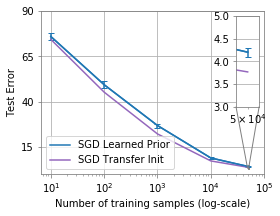

In [6]:
def color_ax(ax, color='gray'):
    ax.grid()
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.tick_params(which='both', color=color)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
# Reported values in Pre-Train Your Loss
ax.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='SGD Learned Prior', color='#1f77b4')
ax.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
ax.plot(df.n[df.method=='nonlearned'], 100*(1-df.test_acc[df.method=='nonlearned']), label='SGD Transfer Init', color='#9467bd')
#ax.errorbar(df.prior_scale, df.test_acc, yerr=df.test_acc_std, fmt='o', capsize=3, color='#9467bd')

axins = zoomed_inset_axes(ax, zoom=25, loc='upper right')
axins.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='SGD Learned Prior', color='#1f77b4')
axins.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
axins.plot(df.n[df.method=='nonlearned'], 100*(1-df.test_acc[df.method=='nonlearned']), label='SGD Transfer Init', color='#9467bd')
axins.set_xlim(49000, 51000)
axins.set_ylim(3, 5)
axins.set_xscale('log')
color_ax(axins)
mark_inset(ax, axins, loc1=3, loc2=4, color='gray')

ax.set_xscale('log')
color_ax(ax)
ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_yticks([15, 40, 65, 90])
ax.set_xlabel('Number of training samples (log-scale)')
ax.set_ylabel('Test Error')
ax.legend(loc='lower left')
plt.show()